<a href="https://colab.research.google.com/github/SahanaDil/UCSD-deep-neural-networks/blob/main/Batch_Normalization_project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Batch Normalization Optimization in Neural Networks

In the previous lecture units, we introduced hyperparameters and demonstrated the basic grid search algorithm to show how hyperparameters can be evaluated and ultimately selected for our model.  We looked at this with respect to the Adam optimizer hyperparameters, beta1 and beta2, but noted that there were several other hyperparameters that we could have evaluated, such as the learning rate.  We concluded the previous unit with a discussion on “learning rate decay” which decreased the hyperparameter over time and reduced the affect of overshooting the minimum in our costs.  But, we know that the learning rate as part of the update process impacts the speed at which we train our network, and by decreasing it, the training becomes even slower.  
Therefore it would be advantageous to find an optimization technique which doesn’t reduce the learning rate.  
In this unit we introduce such a technique called batch normalization.


The following instructions are identified as Steps in the text cells preceding their corresponding code cell. Read through the instructions and write/fill-in the appropriate code in the cells.  

Note, several of the following code cells are duplicates of Part 1 of this assignment.  You may reuse your previous code as needed.

## The Framework

**Step 1:**   
Recreate the Layer, Dense, and Model classes from the previous assignments.  Make sure the Adam optimization is included.

In [ ]:
#imports
import numpy as np

import h5py
import matplotlib.pyplot as plt
import math

from sklearn.datasets import make_circles
from sklearn.model_selection import train_test_split
from sklearn.datasets import make_moons
import seaborn as sns
from matplotlib import cm
from mpl_toolkits.mplot3d import Axes3D


In [ ]:
class Layer:

  def __init__(self, output_units, input_units, activation,initialization, train_or_test):

    self.learning_rate = 0.01

    if initialization == 'he':
      self.weights = np.random.randn(output_units, input_units) * np.sqrt((2/input_units))
    if initialization == 'random':
      self.weights = np.random.randn(output_units, input_units) * 0.01

    self.biases = np.zeros((output_units,1))

    self.activation = activation


  #Sigmoid activation:
  def sigmoid(self, Z):
    Z = np.clip(Z, -500, 500)
    return 1 / (1 + np.exp(-Z))

  #ReLu activation:  return the activation of Z applied to the ReLu function
  def relu(self, Z):
    return np.maximum(0,Z)

  #Tanh activation:  return the activation of Z applied to the tanh function
  #Note, use the numpy tanh function here
  def tanh(self, Z):
    return np.tanh(Z)

  # Backward activations
  # Computes the derivatives of activation functions.
  def activation_backwards(self,Z, dA):
    # Check the activation function then calc the activiation gradient
    #       (e.g. sigmoid_grad, relu_grad, tanh_grad)
    #Sigmoid
    if self.activation == 'sigmoid':
      sigmoid= 1/(1 + np.exp(-Z))
      grad = sigmoid * (1-sigmoid)
      return dA * grad

    elif self.activation == 'relu':
      grad = np.where(Z > 0, 1, 0)
      return dA * grad

    elif self.activation == 'tanh':
      tanh = np.tanh(Z)
      grad = 1 - tanh ** 2
      return dA * grad




  #Abstract methods - will complete in child classes
  def forward(self, X, train_or_test):
      self.X = X
      self.Z = np.dot(self.weights, X) + self.biases
      if self.activation == 'sigmoid':
        self.A = self.sigmoid(self.Z)
      elif self.activation == 'relu':
        self.A = self.relu(self.Z)
      elif self.activation == 'tanh':
        self.A = self.tanh(self.Z)

      return self.A

  def backward(self, dA, optimizer, i):
      m = self.X.shape[0]
      dZ = self.activation_backwards(self.Z, dA)
      self.dW = np.dot(self.X.T, dZ) / m
      self.db = np.sum(dZ, axis=0)/m
      dX = np.dot(dZ, self.W.T)
      return dX

  def update(self, learning_rate, optimizer):
      self.weights -= self.learning_rate * self.dW
      self.biases -= self.learning_rate * self.db

In [ ]:
class Dense(Layer):

  # Inherit from the Layer class.
  def __init__(self, output_units, input_units, activation, initialization='he', train_or_test='train'):
    super().__init__(output_units, input_units, activation, initialization, train_or_test)

    # Initialize moving averages and hyperparameter values.
    self.V_dW = np.zeros_like(self.weights)
    self.V_db = np.zeros_like(self.biases)
    self.beta1 = 0.9
    self.S_dW = np.zeros_like(self.weights)
    self.S_db = np.zeros_like(self.biases)
    self.beta2 = 0.999
    self.epsilon = 1e-8


  # Forward step for a single layer.
  def forward(self, input, train_or_test):
    self.input = input
    Z = np.dot(self.weights, self.input) + self.biases
    self.Z = Z

    if self.activation == "sigmoid":
      A = self.sigmoid(Z)

    elif self.activation == "relu":
      A = self.relu(Z)

    elif self.activation == 'tanh':
      A = self.tanh(Z)

    self.A = A

    assert (self.Z.shape == (self.weights.shape[0], self.A.shape[1]))
    assert (self.A.shape == (self.weights.shape[0], self.input.shape[1]))

    return A


  # Backward step for a single layer.
  def backward(self, dA_prev, optimizer, iteration):
    dZ = self.activation_backwards(self.Z, dA_prev)
    m = self.input.shape[1]
    self.dW = (1 / m) * np.dot(dZ, self.input.T)
    self.db = (1 / m) * np.sum(dZ, axis = 1, keepdims = True)
    dA_prev = np.dot(self.weights.T, dZ)


    # Iteration counter.
    iteration += 1

    # Compute V_dW and V_db using momentum.
    if optimizer == 'momentum':
      self.V_dW = self.beta1 * self.V_dW + (1-self.beta1) * self.dW
      self.V_db = self.beta1 * self.V_db + (1-self.beta1) * self.db

      # Calculate the bias corrected values of V_dW and V_db.
      self.V_dW_corr = self.V_dW/(1-self.beta1**iteration)
      self.V_db_corr = self.V_db/(1-self.beta1**iteration)

    # Calculate S_dW and S_db for RMSprop.
    elif optimizer == 'RMSprop':
      self.S_dW = self.beta2 * self.S_dW + (1 - self.beta2) * (self.dW ** 2)
      self.S_db = self.beta2 * self.S_db + (1 - self.beta2) * (self.db ** 2)

      # Calculate the bias corrected values of S_dW and S_db.
      self.S_dW_corr = self.S_dW/(1-self.beta2**iteration)
      self.S_db_corr = self.S_db/(1-self.beta2**iteration)

    # Calculate V_dW, V_db, S_dW, and S_db for Adam.
    elif optimizer == 'Adam':
      self.V_dW = self.beta1 * self.V_dW + (1-self.beta1) * self.dW
      self.V_db = self.beta1 * self.V_db + (1-self.beta1) * self.db
      self.S_dW = self.beta2 * self.S_dW + (1 - self.beta2) * (self.dW ** 2)
      self.S_db = self.beta2 * self.S_db + (1 - self.beta2) * (self.db ** 2)


      # Bias correct the values.
      self.V_dW_corr = self.V_dW/(1-self.beta1**iteration)
      self.V_db_corr = self.V_db/(1-self.beta1**iteration)
      self.S_dW_corr = self.S_dW/(1-self.beta2**iteration)
      self.S_db_corr = self.S_db/(1-self.beta2**iteration)


    assert (dA_prev.shape == self.input.shape)
    assert (self.dW.shape == self.weights.shape)
    assert (self.db.shape == self.biases.shape)

    return dA_prev

  # Parameter update for a single layer.
  def update(self, learning_rate, optimizer):

    if optimizer == 'gradient descent':
      self.weights = self.weights - learning_rate*self.dW
      self.biases = self.biases - learning_rate*self.db


    # For momentum, update the parameters using the bias corrected values of V_dW and V_db.
    elif optimizer == 'momentum':
      self.weights = self.weights - learning_rate * self.V_dW_corr
      self.biases = self.biases - learning_rate * self.V_db_corr


    # For RMSprop, update the weights using the bias corrected values of S_dW and S_db.
    elif optimizer == 'RMSprop':
      self.weights -= learning_rate * self.dW / (np.sqrt(self.S_dW_corr)+self.epsilon)
      self.biases -= learning_rate * self.db / (np.sqrt(self.S_db_corr)+self.epsilon)

    # For Adam, update the weights using the bias corrected values of V_dW, V_db, S_dW, and S_db.
    elif optimizer == 'Adam':
      self.weights -= learning_rate * self.V_dW_corr / (np.sqrt(self.S_dW_corr)+self.epsilon)
      self.biases -= learning_rate * self.V_db_corr / (np.sqrt(self.S_db_corr)+self.epsilon)


In [ ]:
class Model:

  def __init__(self):
    self.epsilon = 1e-8

  def build(self, network):
    self.network = network

  # Forward propagation.
  def feedforward(self, X, train_or_test):

    # Set the input to X.
    input = X

    # Loop over the layers and call the forward method on each input.
    for l in self.network:
      input = l.forward(input, train_or_test) # We pass train_or_test here to specify if this is training or test time.

    # Set AL to the final value of input (i.e. the output of the final layer).
    AL = input
    assert (AL.shape == (1, X.shape[1]))

    return AL

  # Compute cost - remember to call np.squeeze().
  def compute_cost(self, m, AL, Y):
    cost = (-1 / m) * np.sum(Y * np.log(AL + self.epsilon) + (1 - Y) * np.log(1 - AL + self.epsilon))
    cost = np.squeeze(cost)

    return cost


  # Backpropagate through  layers.
  def backpropagation(self, dAL, optimizer, i):

    # Set dA_prev to dAL.
    dA_prev = dAL

    # Loop over the layers in reverse and call the backward method on each dA_prev.
    for l in reversed(self.network):
      # We pass the optimizer and iteration here so we can compute the backprop steps.
      dA_prev = l.backward(dA_prev, optimizer,i)


  # Parameter update.
  def parameter_update(self, learning_rate, optimizer):

    # Loop over layers and call the update method from each.
    for l in self.network:
      l.update(learning_rate, optimizer)

    ### END CODE HERE ###

  # Sinlge iteration of descent.
  def train(self, X, Y, learning_rate, optimizer, i):

    # Extract number of example from the shape of Y.
    m = Y.shape[1]

    # Compute AL by running forward propagation.
    AL = self.feedforward(X, train_or_test='train')

    # Cost calculation.

    Y = Y.reshape(AL.shape)
    cost = self.compute_cost(m, AL, Y)



    # Initialize backpropagation by calculating dAL.
    dAL = - (np.divide(Y, (AL + self.epsilon)) - np.divide(1 - Y, (1 - AL + self.epsilon)))

    # Backpropagate through layers.
    self.backpropagation(dAL, optimizer, i)

    # Update parameters.
    self.parameter_update(learning_rate, optimizer)

    return cost


  # Function for training loop.
  def fit(self, X_train, Y_train, epochs, learning_rate, batch_size, optimizer='gradient descent', verbose=False, callback=None):

    # Initialize list of costs.
    costs = []

    # Make minibatches from the input data.
    mini_batches_train = self.make_minibatch(X_train, Y_train, batch_size)

    # Loop over epochs.
    for i in range(epochs):

      # Loop over minibatches.
      for mini_batch_X, mini_batch_Y in mini_batches_train:

        # Call the train method and append the cost to the list. Remember to pass the optimizer and iteration number to train().
        cost = self.train(mini_batch_X, mini_batch_Y, learning_rate, optimizer, i)
        # Append the iteration and cost to the list as a tuple.
        costs.append((i, cost))

      if (i % 50 == 0):
        if verbose==True:
          print ("Iteration: {}, cost: {}". format(i, cost))

        if (callback is not None):
          callback(i, X_train, Y_train)

    return costs


  # Predict labels.
  def predict(self, X):

    # Get the predictions (output of the final layer after training). Remember to specify that this is test time.
    predictions = self.feedforward(X, train_or_test='test')

    # Set predictions to either 0 or 1.
    predictions = np.where(predictions > 0.5, 1, 0)
    return predictions

  # Evaluate prediction accuracy.
  def evaluate(self, predictions, Y):

    # calculate accuracy.
    accuracy = (100 - np.mean(np.abs(predictions - Y)) * 100)

    return accuracy


  # Batching function
  def make_minibatch(self, X, Y, mini_batch_size):

    # To make your "random" minibatches the same each time.
    np.random.seed(0)  #Do not change, for grading purposes

    m = X.shape[1]

    # List of minibatches.
    mini_batches = []

    # 1: Shuffle (X, Y)
    permutation = list(np.random.permutation(m))
    shuffled_X = X[:, permutation]
    shuffled_Y = Y[:, permutation].reshape((1,m))

    # 2: Partition (shuffled_X, shuffled_Y). Minus the end case.
    num_complete_minibatches = math.floor(m/mini_batch_size) # number of mini batches of size mini_batch_size in your partitionning
    for k in range(0, num_complete_minibatches):

      mini_batch_X = shuffled_X[:, (k * mini_batch_size) : ((k + 1) * mini_batch_size)]
      mini_batch_Y = shuffled_Y[:, (k * mini_batch_size) : ((k + 1) * mini_batch_size)]

      mini_batch = (mini_batch_X, mini_batch_Y)
      mini_batches.append(mini_batch)

    # 3. Handling the end case (last mini-batch < mini_batch_size)
    if m % mini_batch_size != 0:

      mini_batch_X = shuffled_X[:, (mini_batch_size * math.floor((m / mini_batch_size))) : m]
      mini_batch_Y = shuffled_Y[:, (mini_batch_size * math.floor((m / mini_batch_size))) : m]

      mini_batch = (mini_batch_X, mini_batch_Y)
      mini_batches.append(mini_batch)

    return mini_batches

In [ ]:
# Use matplotlib to plot the costs (same as previous assignment).

def plot(costs):
  # Use *zip() to plot the list of tuples of (iteration, cost).
  iterations, cost_values = zip(*costs)

  plt.plot(iterations, cost_values)
  plt.xlabel("Iteration")
  plt.ylabel("Cost")
  plt.title("Training cost over iteration")

  return plt

## Batch Normalization.
We’ve previously studied the concept of normalization, and you actually used this with a neural network.
For example, recall in the previous course where we built our framework, we tested our binary classifier with image data (that is “cats” and “non-cats”).  
And when working with that image data, we normalized the pixel values to be of mean 0 and variance 1. We did this because it helped the model learn more quickly.

Now Batch normalization uses the same intuition – except instead of only normalizing the input to the very first layer, we’re going to normalize inputs to any given layer.
That means, for example, if we want to use batch normalization for the nth layer, we need to normalize its input, which will be the activations of the (n-1)th layer. More specifically, we need to normalize the batch of activations that correspond to the current minibatch – and this provides a batch normalization.

When we normalize our data, we make all features have mean 0 and variance 1. This in turn means the shape of the cost function changes since no dimensions have greater magnitude than any other, we actually change the contours of the cost function and make it more circular.  In other words, every point on the cost function is equally as far from the minimum. This in turn means that training is faster regardless of where on the function we start.  

We’ll also need to understand the phenomenon called “covariate shift”.  Covariate shift refers to the changing distribution of input variables with respect to different sets of data.  For example, our train data may be from a significantly different distribution to our test data. An example of this might be a training set comprised of high resolution images, whereas the test set is from low quality images

Now when using minibatch descent, you will typically also get covariate shift from the different distributions of each minibatch, which can vary considerably.
Constantly changing input data can hamper training since it forces us to constantly relearn to specific new data, possibly at the cost of generalizing.
Now recall in neural networks, the input to every layer, except the first, is the output of the preceding layer.  That means that layer L’s input is the activations of layer L-1. However, since during training, a neural network is constantly updating its parameters, we get different activations at every step in training.  That means that layer L constantly receives different activations due to changes in the weights at layer ‘L-1’ and ‘L-2’ and so on.  This is what’s known as “internal covariate shift”.  Batch normalization was designed to address this problem. By standardizing the mean and variance of the activations of previous layers, we make layer L’s parameters more robust to changes earlier in the network.
And as a result, limiting internal covariate shift increases independence and stability, which helps accelerate learning.

So how does batch normalization work? Let’s assume we have some activations for layer L, we call that the matrix A(L) - or A activations in the layer L. This matrix will have ’n’ rows (that is, 1  row per feature), and ‘m’ columns (that is 1 per example in the minibatch).   So the activation matrix shape with therefore be ’n by m’.
First, we compute the mean and variance of the current minibatch:
- $\mu=\frac{1}{m}\sum_{i=1}^m{A^{[L](i)}}$  
- $\sigma^2=\frac{1}{m}\sum_{i=1}^m{(A^{[L](i)}-\mu)^2}$

Once we have the mean and variance, we can calculate A_norm.  
- $A^{[L](i)}_{norm}=\frac{A^{[L](i)}-\mu}{\sqrt{\sigma^2 + \epsilon}}$

where epsilon is a very small value and included here for numerical stability (that is, so we avoid any divide-by-zero conditions).   
Here, we’re using ‘sample mean’ and ‘sample variance’ to refer to the mean and variance respectively for the current minibatch.  

We can then calculate the final normalized value, which we’ll call A_out:  
- $A^{[L](i)}_{out}=\gamma A^{[L](i)}_{norm} + \beta$

where gamma and beta are learnable parameters of the model like the weights and biases.   

Gamma and beta basically allow us to set the mean and variance of A_out to whatever we want.
In addition to computing A_out using the mean and variance of the current minibatch, we also keep an exponential moving average (or EMA) of the mean and variance stored.
And at test time, we calculate A_norm and A_out using these EMAs instead of simply the mean and variance of the test time minibatches:  
- $\mu_t = \text{momentum}\cdot \mu_t + (1-\text{ momentum})\cdot \mu_{\theta}$
- $\sigma^2_t = \text{momentum}\cdot \sigma^2_t + (1-\text{ momentum})\cdot \sigma^2_{\theta}$

One final note is that there is debate around whether we should normalize Z[L], which you should recall is the the linear output of layer L, or A[L], the activations of layer L.  
While the original batch normalization paper suggests normalizing Z, empirically normalizing A has proven to be just as (if not more) effective.



**Step 2:**  

Now we are finally ready to implement batch normalization.   
We’re going to implement  a new class called ‘BatchNormalization’ and we’ll use it as a layer in our neural network, which is the typical way you’ll see batch normalization used in deep learning libraries.
You are only going to implement the forward() function of the BatchNormalization layer since the backpropagation steps are relatively complex and less important for you to know.

Let’s begin by initializing some values in the constructor:  

**init():**  

- Initialize epsilon to $1x10^{-8}$.  Again, this will be used for numerical stability.
- Next, initialize gamma with the numpy ‘ones’ function and beta with numpy zeros.  Both will have shape equal to the number of input units by 1.   
- Next, initialize the momentum variable to be 0.99.   We’ll use this in calculating our EMAs of the mean and variance for use at test time.
Lastly, initialize these EMAs as running_mean and running_var, and set both to be 0.

**forward():**  
- First check whether we are training or testing.   
Start with training.  Since our activation matrices contain one column per example, remember to set the axis=1 so that we sum along the columns. Also, set keepdims=True to preserve the extra dimensions as this will be useful in later calculations.
- Then calculate A_norm and A_out in the way we previously discussed.  
- Finally, calculate the running_mean and running_var by calculating the EMAs of the mean and variance using the momentum hyperparameter.
- Now we can move on to the test scenario. Here, we simply calculate A_norm and A_out using the running_mean and running_var.

**backward():**  
- Note that the backward function has been provided to you since the backpropagation steps are relatively complex and less important for you to know as it relates to the batch normalization process.
- Please take a look at the code, though, so you can familiarize yourself with the basics of what’s happening.
- We’re following our usual naming convention here.  For example, ‘dgamma’ is the derivative of the cost with respect to gamma, while dA_norm is the derivative of the cost with respect to A_norm, and so on.  

**update():**  
- Lastly, complete the update function. Here you’ll want to update gamma and beta in the same way as you have done previously for the weights and biases.



In [ ]:
class BatchNormalization():

  def __init__(self, input_units):

    # Initialize values. Use np.ones() to
    # initialize gamma and np.zeros() for beta.
    self.epsilon = 1e-8
    self.gamma = np.ones(input_units)
    self.beta = np.zeros(input_units)
    self.momentum = 0.99
    self.running_mean = np.zeros((input_units, 1))
    self.running_var = np.zeros((input_units, 1))


  def forward(self, input, train_or_test):

    # Store for use in backward pass.
    self.input = input

    # During training.
    if train_or_test == 'train':

      # Calculate the mean and variance for the current minibatch.
      self.sample_mean = np.mean(input, axis=1, keepdims=True)
      self.sample_var = np.var(input, axis=1, keepdims=True)


      # Calculate the normalized value of A using the mean and variance of the current minibatch.
      self.A_norm = (input - self.sample_mean) /np.sqrt(self.sample_var + self.epsilon)
      self.A_out = self.gamma[:,None] * self.A_norm + self.beta[:,None]



      # Calculate the running mean and variance using exponentially weighted moving averages.
      self.running_mean = self.momentum * self.running_mean + (1 - self.momentum) * self.sample_mean
      self.running_var = self.momentum * self.running_var + (1 - self.momentum) * self.sample_var

      return self.A_out

    # At test time.
    elif train_or_test == 'test':

      # Calculate the normalized value of Z using the running mean and variance.
      A_norm = (input - self.running_mean)/np.sqrt(self.running_var + self.epsilon)
      A_out = self.gamma[:,None] * A_norm + self.beta[:,None]

      return A_out


  def backward(self, dA_prev, optimizer, i):

    # Calculate the derivatives with respect to the parameters.
    self.dgamma = np.sum(dA_prev * self.A_norm, axis=1, keepdims=True)
    self.dbeta = np.sum(dA_prev, axis=1, keepdims=True)

    # Calculate the derivative with respect to the normalized output.
    dA_norm = dA_prev * self.gamma[:, None]
    m = self.input.shape[1]
    inv_var = 1./np.sqrt(self.sample_var + self.epsilon)

    # Calculate the derivative with respect to the previous layer's activations.
    dA_prev = (1. / m) * inv_var * (m*dA_norm - np.sum(dA_norm, axis=1, keepdims=True)
          - self.A_norm*np.sum(dA_norm*self.A_norm, axis=1, keepdims=True))


    return dA_prev


  def update(self, learning_rate, optimizer):

    # Update the parameters gamma and beta in the same way as you do for weights and biases.

    dgamma_squeezed = self.dgamma.squeeze()
    dbeta_squeezed = self.dbeta.squeeze()
    self.gamma = self.gamma - learning_rate * dgamma_squeezed
    self.beta = self.beta - learning_rate * dbeta_squeezed




**Step 3-8:**   
You’re now ready to test batch normalization.   
- Instantiate your model and build your network with the same architecture as before.   This time, however add a BatchNormalization layer with 50 units as the 4th layer in the network.  
- So in other words, construct the model with 2 inputs nodes, which is equal to the shape of the planar dataset, Dense layers for hidden layers 1, 2, 3 of 25, 50, 50, BatchNormalization layer of 50 nodes for hidden layer 4, a Dense layer of 25 nodes for hidden layer 5, and an output layer of 1 node.   
- Set each Dense layer’s activation function to ‘relu’ except for the output layer, which should be set to ‘sigmoid’.


TestResults(failed=0, attempted=4)

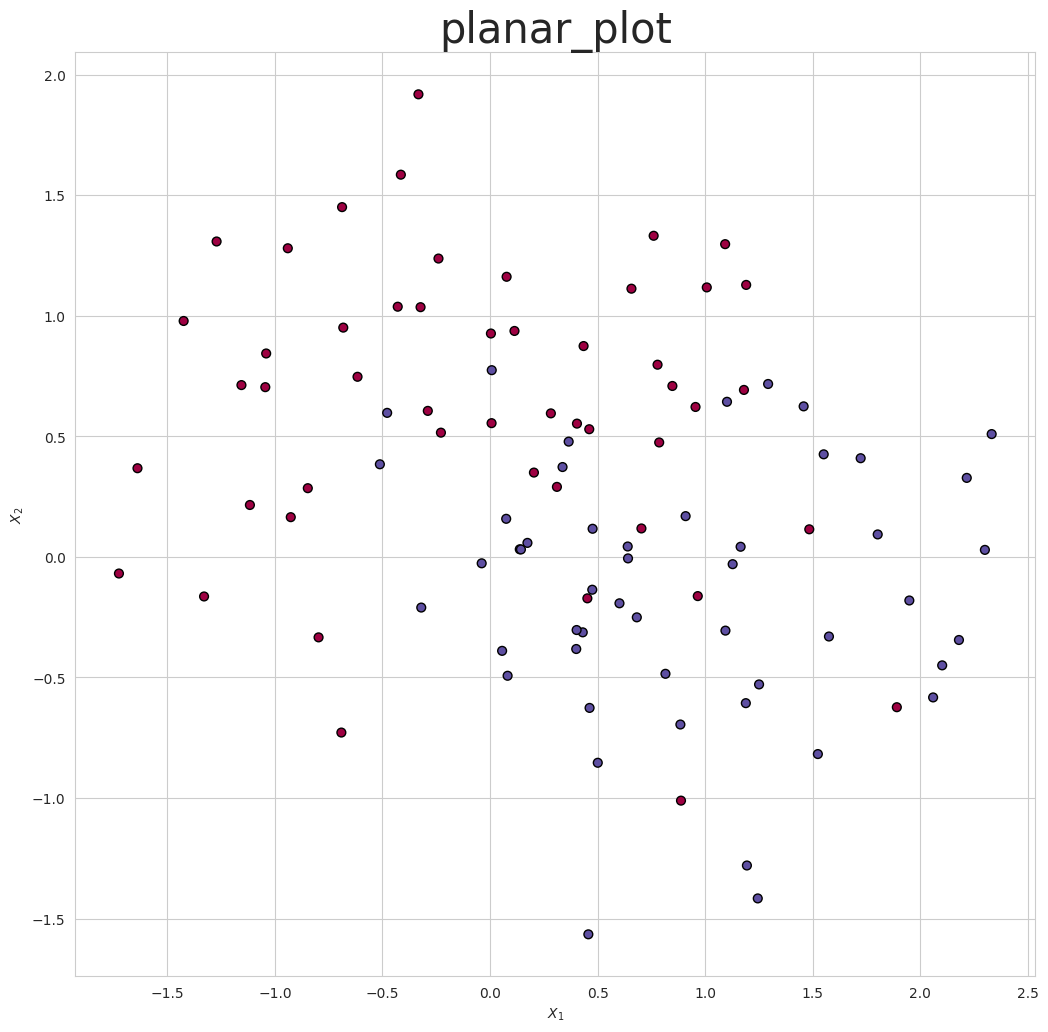

In [ ]:
# number of samples in the data set
N_SAMPLES = 100

# Load the data and split into a train and test set.
X, Y = make_moons(n_samples = N_SAMPLES, noise=0.5, random_state=100)
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.1, random_state=42)
# The function to graph the dataset (same as previous assignment)

def make_plot(X, y, plot_name, file_name=None, XX=None, YY=None, preds=None, dark=False):
    if (dark):
        plt.style.use('dark_background')
    else:
        sns.set_style("whitegrid")
    plt.figure(figsize=(16,12))
    axes = plt.gca()
    axes.set(xlabel="$X_1$", ylabel="$X_2$")
    plt.title(plot_name, fontsize=30)
    plt.subplots_adjust(left=0.20)
    plt.subplots_adjust(right=0.80)
    if(XX is not None and YY is not None and preds is not None):
        plt.contourf(XX, YY, preds.reshape(XX.shape), 25, alpha = 1, cmap=cm.Spectral)
        plt.contour(XX, YY, preds.reshape(XX.shape), levels=[.5], cmap="Greys", vmin=0, vmax=.6)
    plt.scatter(X[:, 0], X[:, 1], c=y.ravel(), s=40, cmap=plt.cm.Spectral, edgecolors='black')
    if(file_name):
        plt.savefig(file_name)
        plt.close()
# Call make_plot (pass X, Y, and the name of the plot only).
make_plot(X, Y, 'planar_plot')
# Reshaping.
X_train = X_train.T
X_test = X_test.T
Y_train = Y_train.reshape(1, Y_train.shape[0])
Y_test = Y_test.reshape(1, Y_test.shape[0])


import doctest

'''
  >>> print(X_train.shape)
  (2, 90)
  >>> print(X_test.shape)
  (2, 10)
  >>> print(Y_train.shape)
  (1, 90)
  >>> print(Y_test.shape)
  (1, 10)
'''

doctest.testmod()

In [ ]:
# Instantiate your model.
model = Model()

# Build a deep neural network. Use a BatchNormalization() layer as the 3rd layer of your network.
model.build([
                Dense(output_units=25 , input_units=2 , activation='relu'),
                Dense(output_units=50 , input_units=25 , activation='relu'),
                Dense(output_units=50 , input_units=50 , activation='relu'),
                BatchNormalization(input_units=50),
                Dense(output_units=25 , input_units=50 , activation='relu'),
                Dense(output_units=1 , input_units=25 , activation='sigmoid'),
])

### END CODE HERE


Fit your model using 3000 epochs, a learning rate of 0.0001, a batch size of 16, and the ‘adam’ optimizer.

In [ ]:
# Use the Adam algorithm by setting the optimizer to 'adam'. Set the batch size to 16.
# Fit your model to the training data with 2000 epochs and a smaller learning_rate of 0.0001.
costs = model.fit(X_train, Y_train, epochs=3000, learning_rate=0.0001, batch_size=16, optimizer='Adam')



Now plot the costs, make predictions, and evaluate accuracy.
You should see that the cost converges quickly, taking only 3000 epochs to get down near 0, which is nearly 3 times faster than Adam without batch normalization.  
You should also find that you have high prediction accuracy for both the training and test sets.  


**********************************************************************
File "__main__", line 3, in __main__
Failed example:
    print(np.round(costs[0][1], 3))
Expected:
    1.505
Got:
    0.976
**********************************************************************
File "__main__", line 5, in __main__
Failed example:
    print(np.round(costs[1500][1], 3))
Expected:
    0.372
Got:
    0.31
**********************************************************************
File "__main__", line 7, in __main__
Failed example:
    print(np.round(costs[2500][1], 3))
Expected:
    0.3
Got:
    0.325
**********************************************************************
File "__main__", line 9, in __main__
Failed example:
    print(np.round(costs[4500][1], 3))
Expected:
    0.316
Got:
    0.153
**********************************************************************
File "__main__", line 11, in __main__
Failed example:
    print(np.round(costs[9000][1], 3))
Expected:
    0.125
Got:
    0.021
***************

TestResults(failed=6, attempted=6)

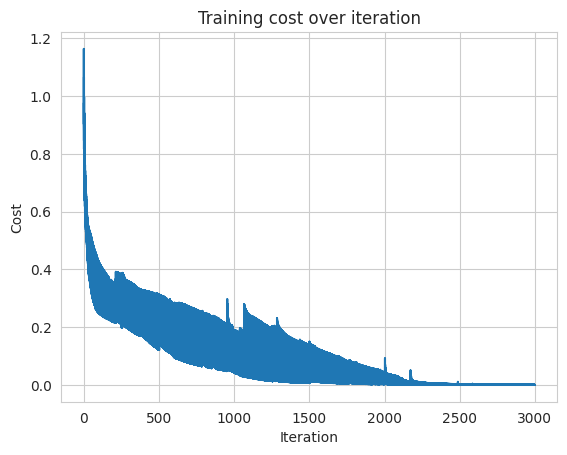

In [ ]:
# Plot the costs.
plot(costs)



# 100 samples / 16 batch size = 6.25 samples per batch
# 6 samples per epoch * 3000 epochs = 18000 costs
import doctest

"""
  >>> print(np.round(costs[0][1], 3))
  1.505
  >>> print(np.round(costs[1500][1], 3))
  0.372
  >>> print(np.round(costs[2500][1], 3))
  0.3
  >>> print(np.round(costs[4500][1], 3))
  0.316
  >>> print(np.round(costs[9000][1], 3))
  0.125
  >>> print(np.round(costs[17999][1], 3))
  0.003
"""

doctest.testmod()

In [ ]:
# Get predictions on the train set.
predictions_train = model.predict(X_train)

# Get predictions on the test set.
predictions_test = model.predict(X_test)



import doctest

"""
  >>> print(predictions_train[0][17])
  1
  >>> print(predictions_train[0][50])
  1
  >>> print(predictions_test[0][1])
  1
  >>> print(predictions_test[0][6])
  1
"""

doctest.testmod()

TestResults(failed=0, attempted=4)

In [ ]:
# Evaluate train accuracy.
model.evaluate(predictions_train, Y_train)


import doctest

"""
  >>> print(np.round(model.evaluate(predictions_train, Y_train), 3))
  86.667
"""

doctest.testmod()

**********************************************************************
File "__main__", line 3, in __main__
Failed example:
    print(np.round(model.evaluate(predictions_train, Y_train), 3))
Expected:
    86.667
Got:
    88.889
**********************************************************************
1 items had failures:
   1 of   1 in __main__
***Test Failed*** 1 failures.


TestResults(failed=1, attempted=1)

In [ ]:
# Evaluate test accuracy.
model.evaluate(predictions_test, Y_test)



import doctest

"""
  >>> print(np.round(model.evaluate(predictions_test, Y_test), 3))
  90.0
"""

doctest.testmod()

TestResults(failed=0, attempted=1)

WHEN YOU COMPLETE THIS SECTION - STOP, AND UPLOAD YOUR COLAB SCRIPT FOR THIS ASSIGNMENT.